In [136]:
import re
import warnings
import numpy as np
import pandas as pd

import datetime
import seaborn as sns
from itertools import chain
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from nltk import tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from tqdm.notebook import tqdm_notebook as tqdm

warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
pd.set_option('max_colwidth',500)

sns.set(rc={'figure.figsize':(9,6),'lines.linewidth': 5, 'lines.markersize': 10})
plt.style.use('seaborn-whitegrid')
sns.set_context("notebook", font_scale=1.2)
sns.set_style("whitegrid",{"font.family": ["Corbel"]})
ROOT_DATA = 'D:/Statistical Programming Projects/Social Network and Sentiment Analysis/data/'

In [137]:
covid_tweets = pd.read_csv(ROOT_DATA+"01_covid_with_topics.csv")
covid_tweets.drop('Unnamed: 0',axis=1,inplace=True)
covid_tweets.head(3)

,id,tweeter_handle,init_reach,timestamp,orig_tweet,likes,retweets,hashtags,mentions,location,retweeted,reply,simplified_tweet,KeyTopic
0,1255285661957054466,seberhagen,604,2020-04-28 23:59:58,It's 7:00 in NYC... #FirstResponders #HealthcareWorkers #EssentialWorkers #NewYork #NY #NYC #Manhattan #MurrayHill #KipsBay #Coronavirus #Covid19 #GroupTherapyNYC @CandisLai https://t.co/EHErM8ngHb,1,0,"FirstResponders, HealthcareWorkers, EssentialWorkers, NewYork, NY, NYC, Manhattan, MurrayHill, KipsBay, Coronavirus, Covid19, GroupTherapyNYC",CandisLai,NaN,NaN,NaN,It's in NYC... FirstResponders HealthcareWorkers EssentialWorkers NewYork NY NYC Manhattan MurrayHill KipsBay Coronavirus Covid19 GroupTherapyNYC,GetPublicWorkerDeathsOutbreak
1,1255285659704725506,diimsa,563,2020-04-28 23:59:58,The @DIIMSA Word Challenge: High School (7:00 PM - 7:05 PM CST). #DIIMSA #DIIMSAVBOARD #DIIMSACHALLENGE #SonyAlpha #ClimateChange #COVID19 #science #remotelearning #remoteworking #pandemic #ScienceWillWin https://t.co/pC82vBAehl,1,0,"DIIMSA, DIIMSAVBOARD, DIIMSACHALLENGE, SonyAlpha, ClimateChange, COVID19, science, remotelearning, remoteworking, pandemic, ScienceWillWin",diimsa,"Houston, TX",NaN,NaN,The Word Challenge: High School - . DIIMSA DIIMSAVBOARD DIIMSACHALLENGE SonyAlpha ClimateChange COVID19 science remotelearning remoteworking pandemic ScienceWillWin,JoinFutureDiscussCrisisLink
2,1255285484395343878,DasBf2pro,20,2020-04-28 23:59:16,NaN,0,0,NaN,NaN,"Kill Devil Hills, NC",1.255233e+18,NaN,NaN,NaN


In [138]:
def remove_links(tweet):
    
    tweet = str(tweet)
    tweet = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+',
                  '',tweet) #remove links from tweet
    tweet = re.sub(r'@[\w]+', '', tweet).strip()
    tweet = re.sub(r'\n', ' ', tweet) ##revome next line characters from the tweet
    tweet = re.sub(r'\xa0','', tweet)#Remove symbols & pictographs
    #tweet = re.sub(r'  ', ' ', tweet) ##revome next line characters from the tweet
    return tweet.strip()

tqdm.pandas()

covid_tweets = covid_tweets[~(covid_tweets.orig_tweet.isnull() & covid_tweets.retweeted.isnull())]


#### Replace after fixing NAs 

In [139]:
for idx,row in tqdm(covid_tweets.iterrows(),total=covid_tweets.shape[0]):
    if not pd.isnull(row['retweeted']):
        try:
            tweet = covid_tweets.orig_tweet[covid_tweets.id==int(row['retweeted'])].tolist()[0]
            covid_tweets.loc[idx,'orig_tweet']= tweet
            covid_tweets.loc[idx,'KeyTopic']=covid_tweets.KeyTopic[covid_tweets.id==int(row['retweeted'])].tolist()[0]
            covid_tweets.loc[idx,'hashtags']=covid_tweets.hashtags[covid_tweets.id==int(row['retweeted'])].tolist()[0]
            covid_tweets.loc[idx,'mentions']=covid_tweets.mentions[covid_tweets.id==int(row['retweeted'])].tolist()[0]
        except:
            continue

In [141]:
covid_tweets['clean_tweet'] = covid_tweets.orig_tweet.progress_apply(remove_links)
tweets = covid_tweets.clean_tweet.tolist()
covid_tweets.clean_tweet.tolist()[0:4]

["It's 7:00 in NYC... #FirstResponders #HealthcareWorkers #EssentialWorkers #NewYork #NY #NYC #Manhattan #MurrayHill #KipsBay #Coronavirus #Covid19 #GroupTherapyNYC",
 'The  Word Challenge: High School (7:00 PM - 7:05 PM CST). #DIIMSA #DIIMSAVBOARD #DIIMSACHALLENGE #SonyAlpha #ClimateChange #COVID19  #science #remotelearning #remoteworking #pandemic #ScienceWillWin',
 'WATCH: U.S. Air Force Thunderbirds and Navy Blue Angels fly over New York City and parts of New Jersey to honor workers on the frontlines of the coronavirus crisis.',
 "Oxford scientists say a vaccine may be widely available by September  A RAY OF HOPE: In the global race to find a vaccine, Oxford University just jumped way ahead of the pack. Human testing is already underway, and scientists say they're hopeful a coronav…"]

In [142]:
sid = SentimentIntensityAnalyzer()
tweets_sentiments = [sid.polarity_scores(tweet) for tweet in tqdm(tweets)]

In [143]:
sentiments = pd.DataFrame(tweets_sentiments)
sentiments.rename(columns={'compound':'Sentiments'},inplace=True)
sentiments.drop(['neg','neu','pos'],axis=1,inplace=True)
covid_tweets = pd.concat([covid_tweets,sentiments],axis=1)
covid_tweets.head(3)

,id,tweeter_handle,init_reach,timestamp,orig_tweet,likes,retweets,hashtags,mentions,location,retweeted,reply,simplified_tweet,KeyTopic,clean_tweet,Sentiments
0,1.255286e+18,seberhagen,604.0,2020-04-28 23:59:58,It's 7:00 in NYC... #FirstResponders #HealthcareWorkers #EssentialWorkers #NewYork #NY #NYC #Manhattan #MurrayHill #KipsBay #Coronavirus #Covid19 #GroupTherapyNYC @CandisLai https://t.co/EHErM8ngHb,1.0,0.0,"FirstResponders, HealthcareWorkers, EssentialWorkers, NewYork, NY, NYC, Manhattan, MurrayHill, KipsBay, Coronavirus, Covid19, GroupTherapyNYC",CandisLai,NaN,NaN,NaN,It's in NYC... FirstResponders HealthcareWorkers EssentialWorkers NewYork NY NYC Manhattan MurrayHill KipsBay Coronavirus Covid19 GroupTherapyNYC,GetPublicWorkerDeathsOutbreak,It's 7:00 in NYC... #FirstResponders #HealthcareWorkers #EssentialWorkers #NewYork #NY #NYC #Manhattan #MurrayHill #KipsBay #Coronavirus #Covid19 #GroupTherapyNYC,0.0000
1,1.255286e+18,diimsa,563.0,2020-04-28 23:59:58,The @DIIMSA Word Challenge: High School (7:00 PM - 7:05 PM CST). #DIIMSA #DIIMSAVBOARD #DIIMSACHALLENGE #SonyAlpha #ClimateChange #COVID19 #science #remotelearning #remoteworking #pandemic #ScienceWillWin https://t.co/pC82vBAehl,1.0,0.0,"DIIMSA, DIIMSAVBOARD, DIIMSACHALLENGE, SonyAlpha, ClimateChange, COVID19, science, remotelearning, remoteworking, pandemic, ScienceWillWin",diimsa,"Houston, TX",NaN,NaN,The Word Challenge: High School - . DIIMSA DIIMSAVBOARD DIIMSACHALLENGE SonyAlpha ClimateChange COVID19 science remotelearning remoteworking pandemic ScienceWillWin,JoinFutureDiscussCrisisLink,The Word Challenge: High School (7:00 PM - 7:05 PM CST). #DIIMSA #DIIMSAVBOARD #DIIMSACHALLENGE #SonyAlpha #ClimateChange #COVID19 #science #remotelearning #remoteworking #pandemic #ScienceWillWin,0.0772
2,1.255285e+18,DasBf2pro,20.0,2020-04-28 23:59:16,WATCH: U.S. Air Force Thunderbirds and Navy Blue Angels fly over New York City and parts of New Jersey to honor workers on the frontlines of the coronavirus crisis.https://t.co/47Qw2bECt1 https://t.co/C4T5Xq0V5O,0.0,0.0,NaN,NaN,"Kill Devil Hills, NC",1.255233e+18,NaN,NaN,WebinarJoinLiveRegisterImpactWorkLearn,WATCH: U.S. Air Force Thunderbirds and Navy Blue Angels fly over New York City and parts of New Jersey to honor workers on the frontlines of the coronavirus crisis.,-0.2263


In [160]:
covid_tweets['timestamp'] = pd.to_datetime(covid_tweets['timestamp']).dt.strftime('%Y-%m-%d %H:%M:%S')
covid_tweets.timestamp = pd.to_datetime(covid_tweets.timestamp)
start_date = datetime.datetime(2020, 4, 18)
end_date = datetime.datetime(2020, 4, 29)
covid_tweets = covid_tweets[covid_tweets.timestamp >= start_date]
covid_tweets = covid_tweets[covid_tweets.timestamp <= end_date]

In [164]:
covid_tweets['Day'] = covid_tweets.timestamp.dt.dayofyear
covid_tweets['Hour'] = covid_tweets.timestamp.dt.hour
covid_tweets=covid_tweets[~pd.isnull(covid_tweets.Day)]
covid_tweets['Day'] = covid_tweets['Day'].astype(int)
covid_tweets['Hour'] = covid_tweets['Hour'].astype(int)
covid_tweets_sentiments = covid_tweets.groupby(['Day','Hour','KeyTopic']).Sentiments.median()
covid_tweets_sentiments = covid_tweets_sentiments.to_frame()
covid_tweets_sentiments.reset_index(inplace=True)

def create_date_time(row):
    date = datetime.datetime(2020,1,1,row['Hour'],0,0) + datetime.timedelta(row['Day'] - 1)
    return date
    
covid_tweets_sentiments['Date'] = covid_tweets_sentiments.progress_apply(create_date_time,axis=1)
covid_tweets_sentiments.head()

,Day,Hour,KeyTopic,Sentiments,Date
0,109,0,GetPublicWorkerDeathsOutbreak,0.2960,2020-04-18 00:00:00
1,109,1,CasesPeopleDiedDetailGlobalNeed,0.0000,2020-04-18 01:00:00
2,109,2,ReportTestStaySafeWork,0.0258,2020-04-18 02:00:00
3,109,4,CasesPeopleDiedDetailGlobalNeed,0.7177,2020-04-18 04:00:00
4,109,4,WebinarJoinLiveRegisterImpactWorkLearn,-0.5994,2020-04-18 04:00:00


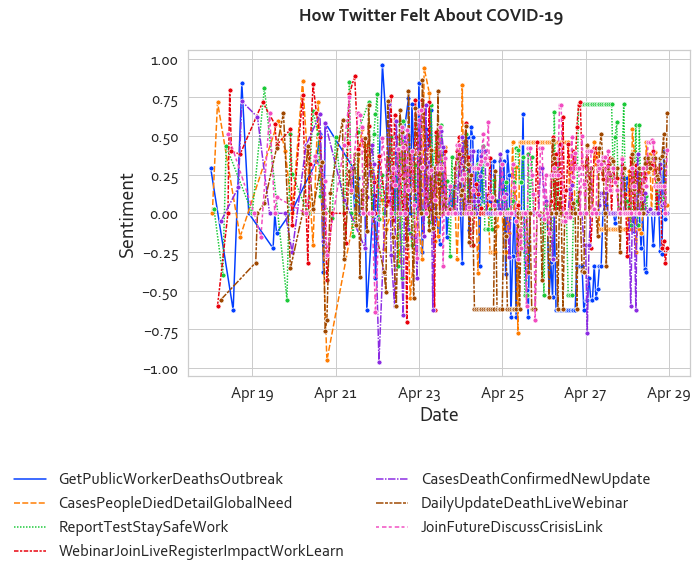

In [165]:
plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16)
fig, axs = plt.subplots(nrows=1,ncols=1,figsize=(9,6))
fig.suptitle("How Twitter Felt About COVID-19",weight='bold').set_fontsize('18')

dash_styles = ["",
               (4, 1.5),
               (1, 1),
               (3, 1, 1.5, 1),
               (5, 1, 1, 1),
               (5, 1, 2, 1, 2, 1),
               (2, 2, 3, 1.5),
               (1, 2.5, 3, 1.2)]
    
axs = sns.lineplot(x="Date",
                  y="Sentiments",
                  ci=None,
                  hue="KeyTopic",
                  palette=sns.color_palette("bright", 7),
                  style="KeyTopic",
                  dashes=dash_styles,
                  marker="o",
                  markersize=5,
                  data=covid_tweets_sentiments)

axs.set_xlabel('Date',fontsize=20)
axs.set_ylabel('Sentiment',fontsize=20)
axs.xaxis.set_major_locator(mdates.AutoDateLocator())
axs.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
handles, labels = axs.get_legend_handles_labels()
plt.legend(handles=handles[1:], labels=labels[1:],fontsize=16,ncol=2, bbox_to_anchor=(.95, -0.25))
for lh in axs.legend_.legendHandles: 
    lh._sizes = [100]
plt.show()

In [166]:
covid_tweets.to_csv(ROOT_DATA+"02_covid_with_sentiments.csv")